In [38]:
from tensorflow import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
import pandas as pd
from sklearn.utils import shuffle
import tensorflow as tf
import xgboost as xgb
import joblib

"""
original_dim = 27
intermediate_dim = 13
latent_dim = 3

inputs = keras.Input(shape=(original_dim,))
x = layers.Dense(intermediate_dim, activation='relu')(inputs)
#x = layers.Dense(intermediate_dim, activation='linear')(inputs)

h = layers.Dense(intermediate_dim, activation='relu')(x)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)



# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
#x = layers.Dense(intermediate_dim, activation='linear')(x)

outputs = layers.Dense(original_dim, activation='linear')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')


optimizer=keras.optimizers.Adam(learning_rate=0.001)
vae.compile(optimizer=optimizer)
"""

"\noriginal_dim = 27\nintermediate_dim = 13\nlatent_dim = 3\n\ninputs = keras.Input(shape=(original_dim,))\nx = layers.Dense(intermediate_dim, activation='relu')(inputs)\n#x = layers.Dense(intermediate_dim, activation='linear')(inputs)\n\nh = layers.Dense(intermediate_dim, activation='relu')(x)\nz_mean = layers.Dense(latent_dim)(h)\nz_log_sigma = layers.Dense(latent_dim)(h)\n\n\n\n# Create encoder\nencoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')\n\n# Create decoder\nlatent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')\nx = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)\n#x = layers.Dense(intermediate_dim, activation='linear')(x)\n\noutputs = layers.Dense(original_dim, activation='linear')(x)\ndecoder = keras.Model(latent_inputs, outputs, name='decoder')\n\n# instantiate VAE model\noutputs = decoder(encoder(inputs)[2])\nvae = keras.Model(inputs, outputs, name='vae_mlp')\n\n\noptimizer=keras.optimizers.Adam(learning_rate=0.001)\nva

# AutoEncoder

## Encoder

In [39]:
original_dim = 27
intermediate_dim = 18
intermediate_dim2 = 8
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))

x = layers.Dense(32, activation='relu')(inputs)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dense(8, activation='relu')(x)
h = layers.Dense(5, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)


### Sampling Layer

In [40]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_sigma = inputs
        
        batch = tf.shape(z_mean)[0]
        
        dim = tf.shape(z_mean)[1]
        
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_sigma) * epsilon

z = Sampling()([z_mean, z_log_sigma])

### Encoder

In [41]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

## Decoder

In [42]:
# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')

x = layers.Dense(8, activation='relu')(latent_inputs)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)

outputs = layers.Dense(original_dim, activation='linear')(x)

decoder = keras.Model(latent_inputs, outputs, name='decoder')

## Full Variational Auto Encoder

In [43]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])

vae = keras.Model(inputs, outputs, name='vae_mlp')

## Loss

In [44]:
#mse = keras.losses.MeanSquaredError()
#reconstruction_loss = mse(inputs, outputs)
#reconstruction_loss *= 27
reconstruction_loss_factor = 1000
reconstruction_loss = tf.keras.backend.mean(tf.keras.backend.square(inputs-outputs))

kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean((reconstruction_loss_factor*reconstruction_loss) + kl_loss)
vae.add_loss(vae_loss)

## Data

In [45]:
dataset = pd.read_csv('datasets/Fs_B_O_DANCE_WALK_KIN_0.5sec.csv')

train_dataset = dataset.sample(frac=0.85, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

print("No Training Samples:",train_dataset.shape[0])
print("No Test Samples:",test_dataset.shape[0])

train_dataset = shuffle(train_dataset)
test_dataset = shuffle(test_dataset)

train_emotions = pd.concat([train_dataset.pop(x) for x in ['EMOTION_P', 'EMOTION_A', 'EMOTION_D']], axis=1)
test_emotions = pd.concat([test_dataset.pop(x) for x in ['EMOTION_P', 'EMOTION_A', 'EMOTION_D']], axis=1)


train_dataset = np.asarray(train_dataset)
test_dataset = np.asarray(test_dataset)

x_train = train_dataset.reshape((len(train_dataset), np.prod(train_dataset.shape[1:])))
x_test = test_dataset.reshape((len(test_dataset), np.prod(test_dataset.shape[1:])))

print(len(x_train[0]))

No Training Samples: 34156
No Test Samples: 6028
27


## Train

In [46]:
optimizer=keras.optimizers.Adam(learning_rate=0.001)
vae.compile(optimizer=optimizer)

In [47]:
vae.fit(x_train, x_train,
        epochs=256,
        batch_size=32,
       )

Epoch 1/256
1068/1068 [==============================] - 2s 2ms/step - loss: 103.5996
Epoch 2/256
1068/1068 [==============================] - 2s 2ms/step - loss: 63.7682
Epoch 3/256
1068/1068 [==============================] - 2s 2ms/step - loss: 60.8491
Epoch 4/256
1068/1068 [==============================] - 2s 2ms/step - loss: 59.1857
Epoch 5/256
1068/1068 [==============================] - 2s 2ms/step - loss: 57.8498
Epoch 6/256
1068/1068 [==============================] - 2s 2ms/step - loss: 56.5210
Epoch 7/256
1068/1068 [==============================] - 2s 2ms/step - loss: 55.4959
Epoch 8/256
1068/1068 [==============================] - 2s 2ms/step - loss: 54.8265
Epoch 9/256
1068/1068 [==============================] - 2s 2ms/step - loss: 54.2963
Epoch 10/256
1068/1068 [==============================] - 2s 2ms/step - loss: 53.7498
Epoch 11/256
1068/1068 [==============================] - 2s 2ms/step - loss: 53.5089
Epoch 12/256
1068/1068 [==============================] - 2s 2

1068/1068 [==============================] - 2s 2ms/step - loss: 49.3526
Epoch 97/256
1068/1068 [==============================] - 2s 2ms/step - loss: 48.6664
Epoch 98/256
1068/1068 [==============================] - 2s 2ms/step - loss: 48.9089
Epoch 99/256
1068/1068 [==============================] - 2s 2ms/step - loss: 48.8820
Epoch 100/256
1068/1068 [==============================] - 2s 2ms/step - loss: 49.0068
Epoch 101/256
1068/1068 [==============================] - 2s 2ms/step - loss: 49.0552
Epoch 102/256
1068/1068 [==============================] - 2s 2ms/step - loss: 50.2897
Epoch 103/256
1068/1068 [==============================] - 2s 2ms/step - loss: 48.7862
Epoch 104/256
1068/1068 [==============================] - 2s 2ms/step - loss: 50.4809
Epoch 105/256
1068/1068 [==============================] - 2s 1ms/step - loss: 49.4187
Epoch 106/256
1068/1068 [==============================] - 2s 2ms/step - loss: 48.2751
Epoch 107/256
1068/1068 [==============================] - 2

1068/1068 [==============================] - 2s 2ms/step - loss: 50.3264
Epoch 191/256
1068/1068 [==============================] - 2s 2ms/step - loss: 50.8126
Epoch 192/256
1068/1068 [==============================] - 2s 2ms/step - loss: 51.2495
Epoch 193/256
1068/1068 [==============================] - 2s 2ms/step - loss: 51.9658
Epoch 194/256
1068/1068 [==============================] - 2s 2ms/step - loss: 51.3365
Epoch 195/256
1068/1068 [==============================] - 2s 2ms/step - loss: 51.5590
Epoch 196/256
1068/1068 [==============================] - 2s 2ms/step - loss: 50.0968
Epoch 197/256
1068/1068 [==============================] - 2s 2ms/step - loss: 49.5463
Epoch 198/256
1068/1068 [==============================] - 2s 2ms/step - loss: 47.0959
Epoch 199/256
1068/1068 [==============================] - 2s 2ms/step - loss: 46.5560
Epoch 200/256
1068/1068 [==============================] - 2s 2ms/step - loss: 46.2696
Epoch 201/256
1068/1068 [==============================] 

## Test

### Sample Comparison & Emotion Classification

In [48]:
sample = np.asarray(x_test[2])
sample = sample.reshape(1,-1)
print(sample)

[[ 0.19247125  0.28036922  0.3565081   0.39190311  0.22840941  0.32371372
   0.17388567  0.2885647   0.286151    0.27877953 -0.09086743 -0.21188509
   0.02295184  0.97239947  0.19451392  0.03909262  0.15768779  0.67337231
   0.69988272  0.17146727  0.36945571  0.67513015  0.15814445  0.31421443
   0.43237798  0.31130308  0.55317533]]


In [49]:
mean, var, generated = encoder.predict(sample)
print(generated)

[[ 0.7809791 -0.2205711]]


In [50]:
regen = decoder.predict(generated)
print(regen)

[[ 0.42736638  0.3043425   0.32455698  0.33913407  0.38387793  0.39833724
   0.30460277  0.31998768  0.28621632  0.27874112  0.0085374  -0.11725329
  -0.07656599  0.9473116   0.25248405  0.1007493   0.13628662  0.2984808
   0.29470652  0.29341814  0.27717263  0.28292072  0.5289943   0.5108364
   0.6786987   0.652297    0.49155465]]


In [51]:
model_p = xgb.XGBRegressor(verbosity=0)
model_p.load_model("../../emotion_classifier/model_training/models/l2p_dance_model_O.json")

model_a = xgb.XGBRegressor(verbosity=0)
model_a.load_model("../../emotion_classifier/model_training/models/l2a_dance_model_O.json")

model_d = xgb.XGBRegressor(verbosity=0)
model_d.load_model("../../emotion_classifier/model_training/models/l2d_dance_model_O.json")

scaler = joblib.load('../../emotion_classifier/model_training/datasets/scalers/standardizers/Fs_B_O_S_DANCE_WALK_KIN_0.5sec.pkl') 

In [52]:
scaled_sample = scaler.transform(sample)

real_coordinates = (
    model_p.predict(scaled_sample),
    model_a.predict(scaled_sample),
    model_d.predict(scaled_sample)
)

scaled_regen = scaler.transform(regen)

generated_coordinates = (
    model_p.predict(scaled_regen),
    model_a.predict(scaled_regen),
    model_d.predict(scaled_regen)
)


print('Real: %s' % np.asarray(real_coordinates))
print('Predicted: %s' % np.asarray(generated_coordinates))

Real: [[-0.06670909]
 [ 0.3034535 ]
 [ 0.0428052 ]]
Predicted: [[-0.19883268]
 [ 0.4595717 ]
 [-0.23107299]]


/home/diogosilva/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/home/diogosilva/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


### MAE & MSE

In [53]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [54]:
mean, var, generated = encoder.predict(x_test)
regen = decoder.predict(generated)

print(regen)

[[0.6329736  0.4300271  0.44331452 ... 1.7292066  1.9863312  1.7494383 ]
 [0.61431366 0.4117009  0.42325303 ... 1.9108126  2.0700026  1.6242664 ]
 [0.41318393 0.29644912 0.31860033 ... 0.61399335 0.58911777 0.4325329 ]
 ...
 [0.33170357 0.24836792 0.2439726  ... 0.5929428  0.89926857 0.4043101 ]
 [0.4012252  0.2808137  0.2891276  ... 0.89190197 1.0850956  0.9394088 ]
 [0.4339701  0.29001844 0.29367697 ... 2.1026216  1.6826086  1.2694185 ]]


In [55]:
mae_errors = mean_absolute_error(x_test, regen, multioutput='raw_values')
mse_errors = mean_squared_error(x_test, regen, multioutput='raw_values')

features = ["max_hand_distance",
          "avg_l_hand_hip_distance",
          "avg_r_hand_hip_distance",
          "max_stride_length",
          "avg_l_hand_chest_distance",
          "avg_r_hand_chest_distance",
          "avg_l_elbow_hip_distance",
          "avg_r_elbow_hip_distance",
          "avg_chest_pelvis_distance",
          "avg_neck_chest_distance",
          "avg_neck_rotation_w", "avg_neck_rotation_x", "avg_neck_rotation_y", "avg_neck_rotation_z",
          "avg_total_body_volume",
          "avg_triangle_area_hands_neck",
          "avg_triangle_area_feet_hips",
          
          "l_hand_speed",
          "r_hand_speed",
          "l_foot_speed",
          "r_foot_speed",
          "neck_speed",
          
          "l_hand_acceleration_magnitude",
          "r_hand_acceleration_magnitude",
          "l_foot_acceleration_magnitude",
          "r_foot_acceleration_magnitude",
          "neck_acceleration_magnitude",
         ]

print("Overall MAE: " + str(mean_absolute_error(x_test, regen)))

print()
for i in range(len(mse_errors)):
    print("==" + features[i] + "==")
    print("MSE: %.5f" % mse_errors[i])
    print("MAE: %.5f" % mae_errors[i])
    print("Example [Regen-Real]: " + str(regen[i][i]) + " - " + str(x_test[i][i]))
    print()

Overall MAE: 0.12698743410522761

==max_hand_distance==
MSE: 0.04889
MAE: 0.17066
Example [Regen-Real]: 0.6329736 - 0.8624994836576182

==avg_l_hand_hip_distance==
MSE: 0.01736
MAE: 0.10246
Example [Regen-Real]: 0.4117009 - 0.766408014619991

==avg_r_hand_hip_distance==
MSE: 0.02148
MAE: 0.11701
Example [Regen-Real]: 0.31860033 - 0.3565080956418642

==max_stride_length==
MSE: 0.01795
MAE: 0.10292
Example [Regen-Real]: 0.27583423 - 0.1885405624466986

==avg_l_hand_chest_distance==
MSE: 0.01077
MAE: 0.08239
Example [Regen-Real]: 0.44711012 - 0.4915204878199241

==avg_r_hand_chest_distance==
MSE: 0.01066
MAE: 0.08134
Example [Regen-Real]: 0.43496868 - 0.4369089205373691

==avg_l_elbow_hip_distance==
MSE: 0.00484
MAE: 0.05276
Example [Regen-Real]: 0.3422255 - 0.3524525357100085

==avg_r_elbow_hip_distance==
MSE: 0.00506
MAE: 0.05289
Example [Regen-Real]: 0.29718095 - 0.2859400406983174

==avg_chest_pelvis_distance==
MSE: 0.00000
MAE: 0.00008
Example [Regen-Real]: 0.28622994 - 0.28615100000

<Figure size 432x432 with 0 Axes>

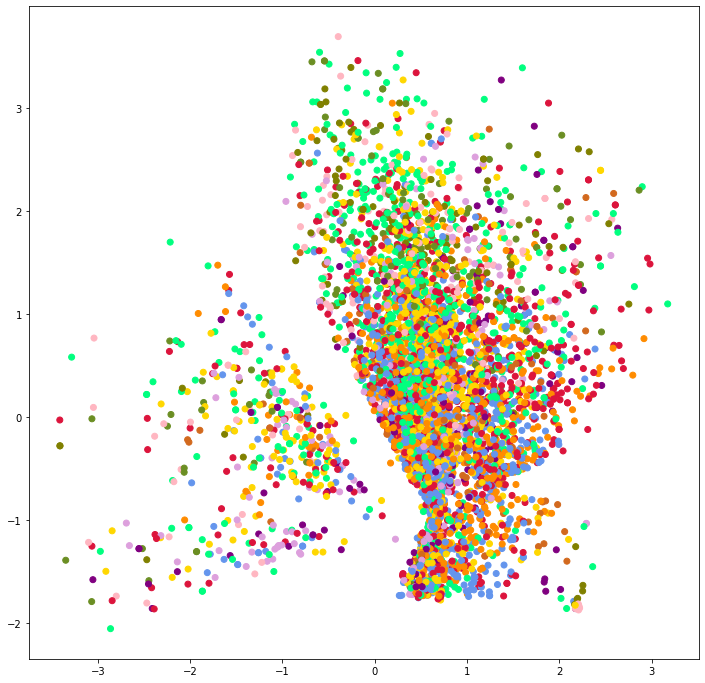

In [56]:
conv_dict = {
    (-0.5, 0.6, 0.9): "angry",
    (0.6, 0.5, 0.2): "happy",
    (-0.6, -0.3, -0.3): "sad",
    (-0.4, 0.25, -0.1): "disgusted",
    (-0.35, 0.7, -0.8): "afraid",
    (0.7, 0.2, 0.2): "pleased",
    (-0.5, -0.7, -0.25): "bored",
    (0.1, -0.7, -0.2): "tired",
    (0.6, -0.55, 0.1): "relaxed",
    (0.5, 0.7, 0.4): "excited",
    (-0.85, -0.1, -0.8): "miserable",
    (-0.3, -0.66, -0.7): "nervous",
    (0.9, -0.25, 0.65): "satisfied",   
}

colour_dict = {
    "angry": "crimson",
    "happy": "springgreen",
    "sad": "cornflowerblue",
    "disgusted": "darkorange"  ,
    "afraid": "gold",
    "pleased": "olive",
    "bored": "lightseagreen",
    "tired": "plum",
    "relaxed": "chocolate",
    "excited": "olivedrab",
    "miserable": "purple",
    "nervous": "lightslategray",
    "satisfied": "lightpink",   
}

x_test_encoded = encoder.predict(x_test, batch_size=32)
plt.figure(figsize=(6, 6))
test_y = []
for i in range(len(test_emotions)):
    point_coords = (test_emotions.iloc[i][0], test_emotions.iloc[i][1], test_emotions.iloc[i][2])
    
    test_y.append(colour_dict[conv_dict[point_coords]])

plt.figure(figsize=(12, 12))
plt.scatter(x_test_encoded[0][:, 0], x_test_encoded[0][:, 1], c=test_y)
plt.show()

# PAD to Latent Space

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.lines as mlines

import tensorflow as tf

import sklearn
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

import xgboost as xgb

xgb.set_config(verbosity=0)

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import normalize

from sklearn.utils import shuffle
import math
import joblib

from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time


## Create Dataset

In [58]:
model_p = xgb.XGBRegressor(verbosity=0)
model_p.load_model("../../emotion_classifier/model_training/models/l2p_dance_model_O.json")

model_a = xgb.XGBRegressor(verbosity=0)
model_a.load_model("../../emotion_classifier/model_training/models/l2a_dance_model_O.json")

model_d = xgb.XGBRegressor(verbosity=0)
model_d.load_model("../../emotion_classifier/model_training/models/l2d_dance_model_O.json")

scaler = joblib.load('../../emotion_classifier/model_training/datasets/scalers/standardizers/Fs_B_O_S_DANCE_WALK_KIN_0.5sec.pkl') 

## Data

In [59]:
# X -> Predicted emotions of LMA features
# y -> Latent Space of LMA features
# Good Error: Predicted emotion of LMA features generated from latent space == Predicted emotions of original LMA features

dataset = pd.read_csv('../../emotion_classifier/model_training/datasets/Fs_B_O_S_DANCE_WALK_KIN_0.5sec.csv')

train_dataset = dataset.sample(frac=0.85, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

print("No Training Samples:",train_dataset.shape[0])
print("No Test Samples:",test_dataset.shape[0])

train_lma = train_dataset.copy()
test_lma = test_dataset.copy()

train_emotions = pd.concat([train_lma.pop(x) for x in ['EMOTION_P', 'EMOTION_A', 'EMOTION_D']], axis=1)
test_emotions = pd.concat([test_lma.pop(x) for x in ['EMOTION_P', 'EMOTION_A', 'EMOTION_D']], axis=1)

No Training Samples: 34156
No Test Samples: 6028


In [60]:
train_X_p = model_p.predict(train_lma)
train_X_a = model_a.predict(train_lma)
train_X_d = model_d.predict(train_lma)

rows = []
for i in range(len(train_lma)):
    rows.append([train_X_p[i], train_X_a[i], train_X_d[i]])

train_X = pd.DataFrame(rows, columns=[
            "EMOTION_P", "EMOTION_A", "EMOTION_D"
         ])

train_X.head()

,EMOTION_P,EMOTION_A,EMOTION_D
0,0.596379,0.498261,0.199826
1,0.699091,0.199438,0.199085
2,-0.586425,-0.288315,-0.289255
3,-0.350705,0.698464,-0.799689
4,-0.351387,0.699263,-0.800516


In [61]:
test_X_p = model_p.predict(test_lma)
test_X_a = model_a.predict(test_lma)
test_X_d = model_d.predict(test_lma)

rows = []
for i in range(len(test_lma)):
    rows.append([test_X_p[i], test_X_a[i], test_X_d[i]])

test_X = pd.DataFrame(rows, columns=[
            "EMOTION_P", "EMOTION_A", "EMOTION_D"
         ])

test_X.head()

,EMOTION_P,EMOTION_A,EMOTION_D
0,-0.499540,0.599887,0.896598
1,0.599478,0.496702,0.201141
2,-0.581306,-0.292542,-0.287728
3,-0.602087,-0.301238,-0.288370
4,-0.595353,-0.301161,-0.302442


In [62]:
mean, var, latent_space = encoder.predict(train_lma)

rows = []
for i in range(len(latent_space)):
    rows.append([latent_space[i][0], latent_space[i][1]])#, latent_space[i][2]])
    
train_y = pd.DataFrame(rows, columns=[
            "LATENT_1", "LATENT_2" #, "LATENT_3"
         ])

train_y_1 = pd.concat([train_y.pop(x) for x in ['LATENT_1']], axis=1)
train_y_2 = pd.concat([train_y.pop(x) for x in ['LATENT_2']], axis=1)
#train_y_3 = pd.concat([train_y.pop(x) for x in ['LATENT_3']], axis=1)

train_y_1.head()

,LATENT_1
0,0.784062
1,7.159323
2,2.051166
3,1.862149
4,0.101067


In [63]:
mean, var, latent_space = encoder.predict(test_lma)

rows = []
for i in range(len(latent_space)):
    rows.append([latent_space[i][0], latent_space[i][1]])#, latent_space[i][2]])
    
test_y = pd.DataFrame(rows, columns=[
            "LATENT_1", "LATENT_2" #, "LATENT_3"
         ])

test_y_1 = pd.concat([test_y.pop(x) for x in ['LATENT_1']], axis=1)
test_y_2 = pd.concat([test_y.pop(x) for x in ['LATENT_2']], axis=1)
#test_y_3 = pd.concat([test_y.pop(x) for x in ['LATENT_3']], axis=1)

test_y_1.head()

,LATENT_1
0,4.773103
1,1.324894
2,2.013645
3,4.986722
4,2.623474


## Train Regressor

In [64]:
model_1 = xgb.XGBRegressor(
                    n_estimators=1500, learning_rate=0.05, max_depth=10, min_child_weight=5, 
                    reg_alpha=0.1, reg_lambda=1, gamma=0.0,
                    subsample=0.75, colsample_bytree=0.75, objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

model_2 = xgb.XGBRegressor(
                    n_estimators=1500, learning_rate=0.05, max_depth=10, min_child_weight=5, 
                    reg_alpha=0.1, reg_lambda=1, gamma=0.0,
                    subsample=0.75, colsample_bytree=0.75, objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

#model_3 = xgb.XGBRegressor(
#                    n_estimators=1500, learning_rate=0.05, max_depth=10, min_child_weight=5, 
#                    reg_alpha=0.1, reg_lambda=1, gamma=0.0,
#                    subsample=0.75, colsample_bytree=0.75, objective="reg:squarederror",
#                    tree_method='gpu_hist'
#                )

In [65]:
model_1.fit(train_X, train_y_1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.75,
             enable_categorical=False, gamma=0.0, gpu_id=0,
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=10,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=1500, n_jobs=12, num_parallel_tree=1,
             predictor='auto', random_state=0, reg_alpha=0.1, reg_lambda=1,
             scale_pos_weight=1, subsample=0.75, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)

In [66]:
model_2.fit(train_X, train_y_2)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.75,
             enable_categorical=False, gamma=0.0, gpu_id=0,
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=10,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=1500, n_jobs=12, num_parallel_tree=1,
             predictor='auto', random_state=0, reg_alpha=0.1, reg_lambda=1,
             scale_pos_weight=1, subsample=0.75, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)

In [67]:
#model_3.fit(train_X, train_y_3)

## Test Model

In [68]:
score = model_1.score(train_X, train_y_1)  

print("Latent 1")
print("Training score: ", score)

print()

score = model_2.score(train_X, train_y_2)  

print("Latent 2")
print("Training score: ", score)

#score = model_3.score(train_X, train_y_3)  

#print()

#print("Latent 3")
#print("Training score: ", score)

Latent 1
Training score:  0.5978569664774622

Latent 2
Training score:  0.6709893006262049


In [69]:
pred_y_1 = model_1.predict(test_X)
mse = mean_squared_error(test_y_1, pred_y_1)
mae = mean_absolute_error(test_y_1, pred_y_1)
print("Latent 1")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)


pred_y_2 = model_2.predict(test_X)
mse = mean_squared_error(test_y_2, pred_y_2)
mae = mean_absolute_error(test_y_2, pred_y_2)
print("\nLatent 2")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)


#pred_y_3 = model_3.predict(test_X)
#mse = mean_squared_error(test_y_3, pred_y_3)
#mae = mean_absolute_error(test_y_3, pred_y_3)
#print("\nLatent 3")
#print("MSE: %.2f" % mse)
#print("MAE: %.2f" % mae)

Latent 1
MSE: 2.59
MAE: 1.23

Latent 2
MSE: 0.94
MAE: 0.75


In [70]:
index = 2

# Real -> PAD coordinates
#   - get latent space
#   - convert from latent to LMA features
#   - standardize
#   - predict coordinates of generated features

sample = np.asarray([test_X.iloc[index]])
latent = np.asarray([[model_1.predict(sample)[0], model_2.predict(sample)[0]]])#, model_3.predict(sample)[0]]])


generated_lma = decoder.predict(latent)


scaled_gen = scaler.transform(generated_lma)

generated_coord = (
    model_p.predict(scaled_gen)[0],
    model_a.predict(scaled_gen)[0],
    model_d.predict(scaled_gen)[0]
)

print('Real: %s' % sample[0])
print('Predicted: %s' % np.asarray(generated_coord))

Real: [-0.5813058  -0.29254228 -0.28772822]
Predicted: [-0.29099813  0.26557478 -0.10210333]


/home/diogosilva/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


## RandomSearchCV

In [ ]:
# A parameter grid for XGBoost
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
params = {
        'eta': [0.01, 0.05, 0.1],
        'min_child_weight': [1, 5, 11, 21],
        'max_depth': [3, 6, 10, 15],
        'gamma': [0, 0.001, 0.01],
        'subsample': [0.75, 1],
        'colsample_bytree': [0.75, 1],
        'lambda': [1, 1.25],
        'alpha': [0.0, 0.25]
        }

n_iter = 150

In [ ]:
model_1 = xgb.XGBRegressor(
                    n_estimators=1500,
                    objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

model_2 = xgb.XGBRegressor(
                    n_estimators=1500,
                    objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

In [ ]:
# Latent 1
# run randomized search
kfold = KFold(n_splits=5, shuffle=True)

random_search_1 = RandomizedSearchCV(model_1, param_distributions=params,
                               cv=kfold, scoring='neg_mean_squared_error', n_iter = n_iter)

start = time.time()
random_search_1.fit(train_X, train_y_1)


print("GridSearchCV took %.2f seconds"
      " parameter settings." % ((time.time() - start)))

In [ ]:
# Latent 2
# run randomized search
kfold = KFold(n_splits=5, shuffle=True)

random_search_2 = RandomizedSearchCV(model_2, param_distributions=params,
                               cv=kfold, scoring='neg_mean_squared_error', n_iter = n_iter)

start = time.time()
random_search_2.fit(train_X, train_y_2)


print("GridSearchCV took %.2f seconds"
      " parameter settings." % ((time.time() - start)))

### Results

In [ ]:
best_regressor_1 = random_search_1.best_estimator_

print(best_regressor_1.get_params())

In [ ]:
best_regressor_2 = random_search_2.best_estimator_

print(best_regressor_2.get_params())

In [ ]:
pred_y_1 = best_regressor_1.predict(test_X)
mse = mean_squared_error(test_y_1, pred_y_1)
mae = mean_absolute_error(test_y_1, pred_y_1)
print("Latent 1")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)


pred_y_2 = best_regressor_2.predict(test_X)
mse = mean_squared_error(test_y_2, pred_y_2)
mae = mean_absolute_error(test_y_2, pred_y_2)
print("\nLatent 2")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

## PAD to Latent Space using NN

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.lines as mlines

import tensorflow as tf

import sklearn
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

import xgboost as xgb

xgb.set_config(verbosity=0)

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import normalize

from sklearn.utils import shuffle
import math
import joblib

from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time


## Create Dataset

In [ ]:
model_p = xgb.XGBRegressor(verbosity=0)
model_p.load_model("../../emotion_classifier/model_training/models/l2p_dance_model_O.json")

model_a = xgb.XGBRegressor(verbosity=0)
model_a.load_model("../../emotion_classifier/model_training/models/l2a_dance_model_O.json")

model_d = xgb.XGBRegressor(verbosity=0)
model_d.load_model("../../emotion_classifier/model_training/models/l2d_dance_model_O.json")

scaler = joblib.load('../../emotion_classifier/model_training/datasets/scalers/standardizers/Fs_B_O_S_DANCE_WALK_KIN_0.5sec.pkl') 

## Data

In [26]:
# X -> Predicted emotions of LMA features
# y -> Latent Space of LMA features
# Good Error: Predicted emotion of LMA features generated from latent space == Predicted emotions of original LMA features

dataset = pd.read_csv('../../emotion_classifier/model_training/datasets/Fs_B_O_S_DANCE_WALK_KIN_0.5sec.csv')

train_dataset = dataset.sample(frac=0.85, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

print("No Training Samples:",train_dataset.shape[0])
print("No Test Samples:",test_dataset.shape[0])

train_lma = train_dataset.copy()
test_lma = test_dataset.copy()

train_emotions = pd.concat([train_lma.pop(x) for x in ['EMOTION_P', 'EMOTION_A', 'EMOTION_D']], axis=1)
test_emotions = pd.concat([test_lma.pop(x) for x in ['EMOTION_P', 'EMOTION_A', 'EMOTION_D']], axis=1)

No Training Samples: 34156
No Test Samples: 6028


In [27]:
train_X_p = model_p.predict(train_lma)
train_X_a = model_a.predict(train_lma)
train_X_d = model_d.predict(train_lma)

rows = []
for i in range(len(train_lma)):
    rows.append([train_X_p[i], train_X_a[i], train_X_d[i]])

train_X = pd.DataFrame(rows, columns=[
            "EMOTION_P", "EMOTION_A", "EMOTION_D"
         ])

train_X.head()

,EMOTION_P,EMOTION_A,EMOTION_D
0,0.596379,0.498261,0.199826
1,0.699091,0.199438,0.199085
2,-0.586425,-0.288315,-0.289255
3,-0.350705,0.698464,-0.799689
4,-0.351387,0.699263,-0.800516


In [28]:
test_X_p = model_p.predict(test_lma)
test_X_a = model_a.predict(test_lma)
test_X_d = model_d.predict(test_lma)

rows = []
for i in range(len(test_lma)):
    rows.append([test_X_p[i], test_X_a[i], test_X_d[i]])

test_X = pd.DataFrame(rows, columns=[
            "EMOTION_P", "EMOTION_A", "EMOTION_D"
         ])

test_X.head()

,EMOTION_P,EMOTION_A,EMOTION_D
0,-0.499540,0.599887,0.896598
1,0.599478,0.496702,0.201141
2,-0.581306,-0.292542,-0.287728
3,-0.602087,-0.301238,-0.288370
4,-0.595353,-0.301161,-0.302442


In [29]:
mean, var, latent_space = encoder.predict(train_lma)

rows = []
for i in range(len(latent_space)):
    rows.append([latent_space[i][0], latent_space[i][1]])#, latent_space[i][2]])
    
train_y = pd.DataFrame(rows, columns=[
            "LATENT_1", "LATENT_2" #, "LATENT_3"
         ])

train_y.head()

,LATENT_1,LATENT_2
0,0.361722,0.243057
1,1.391273,6.868157
2,-0.424139,2.800301
3,-3.369422,0.406657
4,-6.349014,-0.608331


In [30]:
mean, var, latent_space = encoder.predict(test_lma)

rows = []
for i in range(len(latent_space)):
    rows.append([latent_space[i][0], latent_space[i][1]])#, latent_space[i][2]])
    
test_y = pd.DataFrame(rows, columns=[
            "LATENT_1", "LATENT_2" #, "LATENT_3"
         ])

test_y.head()

,LATENT_1,LATENT_2
0,1.447710,3.733032
1,-0.346867,0.527793
2,-1.267642,0.937234
3,-11.860671,-2.363246
4,-1.496551,0.931208


### Define Model

In [31]:
# Create decoder
input_layer = keras.Input(shape=(3,), name='input_layer')

pad_latent_h = layers.Dense(50, activation='relu')(input_layer)
pad_latent_h = layers.Dense(20, activation='relu')(input_layer)
pad_latent_h = layers.Dense(10, activation='relu')(input_layer)

pad_latent_output = layers.Dense(2, activation='linear')(pad_latent_h)

pad_to_latent_model = keras.Model(input_layer, pad_latent_output, name='pad_latent')

In [32]:
def emotional_loss(y_true, y_pred):
    true_generated = decoder.predict(y_true)
    pred_generated = decoder.predict(y_pred)

    scaled_true = scaler.transform(true_generated)
    scaled_pred = scaler.transform(pred_generated)
    
    true_coord = [[model_p.predict(x)[0], model_a.predict(x)[0], model_d.predict(x)[0]] for x in scaled_true]
    pred_coord = [[model_p.predict(x)[0], model_a.predict(x)[0], model_d.predict(x)[0]] for x in scaled_pred]

    mse = keras.losses.MeanSquaredError()
    loss = mse(true_coord, pred_coord)


### Train Model

In [33]:
optimizer=keras.optimizers.Adam(learning_rate=0.1)
pad_to_latent_model.compile(loss='mean_squared_error', optimizer=optimizer)

In [34]:
pad_to_latent_model.fit(train_X, train_y,
        epochs=1024,
        batch_size=32,
       )

Epoch 1/1024
1068/1068 [==============================] - 1s 749us/step - loss: 14.8684
Epoch 2/1024
1068/1068 [==============================] - 1s 719us/step - loss: 14.7994
Epoch 3/1024
1068/1068 [==============================] - 1s 720us/step - loss: 14.8004
Epoch 4/1024
1068/1068 [==============================] - 1s 713us/step - loss: 14.7576
Epoch 5/1024
1068/1068 [==============================] - 1s 728us/step - loss: 14.7726
Epoch 6/1024
1068/1068 [==============================] - 1s 710us/step - loss: 14.7810
Epoch 7/1024
1068/1068 [==============================] - 1s 724us/step - loss: 14.7647
Epoch 8/1024
1068/1068 [==============================] - 1s 727us/step - loss: 14.7610
Epoch 9/1024
1068/1068 [==============================] - 1s 705us/step - loss: 14.7896
Epoch 10/1024
1068/1068 [==============================] - 1s 701us/step - loss: 14.7807
Epoch 11/1024
1068/1068 [==============================] - 1s 699us/step - loss: 14.7930
Epoch 12/1024
1068/1068 [=====

1068/1068 [==============================] - 1s 716us/step - loss: 14.8291
Epoch 94/1024
1068/1068 [==============================] - 1s 709us/step - loss: 14.8610
Epoch 95/1024
1068/1068 [==============================] - 1s 729us/step - loss: 14.8514
Epoch 96/1024
1068/1068 [==============================] - 1s 751us/step - loss: 14.8464
Epoch 97/1024
1068/1068 [==============================] - 1s 725us/step - loss: 14.8566
Epoch 98/1024
1068/1068 [==============================] - 1s 739us/step - loss: 14.8153
Epoch 99/1024
1068/1068 [==============================] - 1s 768us/step - loss: 14.8475
Epoch 100/1024
1068/1068 [==============================] - 1s 732us/step - loss: 14.8481
Epoch 101/1024
1068/1068 [==============================] - 1s 748us/step - loss: 14.8602
Epoch 102/1024
1068/1068 [==============================] - 1s 733us/step - loss: 14.8387
Epoch 103/1024
1068/1068 [==============================] - 1s 719us/step - loss: 14.8578
Epoch 104/1024
1068/1068 [=====

KeyboardInterrupt: 